# MNIST Convolutional Neural Network - 2nd model
This time we are going to implement the same model used by Dan Ciresan, Ueli Meier and Jurgen Schmidhuber in 2012. The model should have an error of 0.23% and it's quite similar to the previous one we implemented from Keras documentation. The network was not only one of the best for MNIST, ranking second best at the moment, but also very good on NIST SD 19 and NORB. 

We are also going to use Keras checkpoints because of the many epochs required by the model.

Again for this notebook we are going to use **TensorFlow** with **Keras**.

In [1]:
import tensorflow as tf 
# We don't really need to import TensorFlow here since it's handled by Keras, 
# but we do it in order to output the version we are using.

In [2]:
tf.__version__

'0.12.1'

We are using TensorFlow-GPU 0.12.1 on Python 3.5.2, running on Windows 10 with Cuda 8.0. 

We have 3 machines with the same environment and 3 different GPUs, respectively with 384, 1024 and 1664 Cuda cores.

## Imports

In [3]:
import os.path
from IPython.display import Image

from util import Util
u = Util()

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)  

In [4]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils.visualize_util import plot
model_image_path = 'images/model_02_MNIST.png'
from keras import backend as K

Using TensorFlow backend.


In [5]:
from keras.datasets import mnist

## Definitions

In [6]:
batch_size = 128
nb_classes = 10
nb_epoch = 800
checkpoints_filepath_tanh = "checkpoints/02_MNIST_tanh_weights.best.hdf5"
checkpoints_filepath_relu = "checkpoints/02_MNIST_relu_weights.best.hdf5"

In [7]:
# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters1 = 20
nb_filters2 = 40
# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dense layer size
dense_layer_size1 = 150
# dropout rate
dropout = 0.15

## Data load

In [8]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

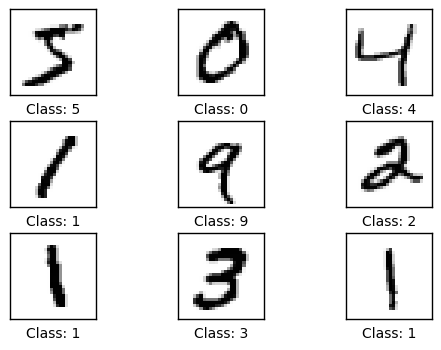

In [9]:
u.plot_images(X_train[0:9], y_train[0:9])

In [10]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [12]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Model definition
The model is structurally similar to the previous one, with 2 Convolutional layers and 1 Fully conneted layers. 
However there are major difference in values and sizes, and also there is one more intermediate max pooling layer and the activation function is a scaled hyperbolic tangent, as described in the [paper](http://people.idsia.ch/~ciresan/data/cvpr2012.pdf). However, since Rectified Linear Units started spreading after 2015, we are going to compare two different CNN, one using tanh (as in the paper) and the other one using relu.

**1x29x29-20C4-MP2-40C5-MP3-150N-10N DNN**.
<img src="images/cvpr2012.PNG" alt="1x29x29-20C4-MP2-40C5-MP3-150N-10N DNN" style="width: 400px;"/>

The paper doesn't seem to use any dropout layer to avoid overfitting, so we're going to use a dropout of 0.15, way lower then we did before. 

The training should take 800 epochs, but for this notebook we'll only do 100 for each run, loading the previous one from checkpoints and see if the progression is the same as described in the paper.

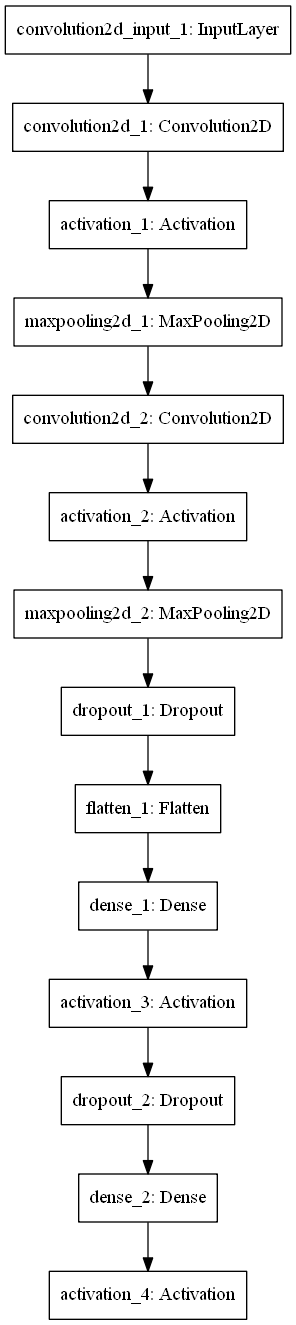

In [13]:
model_tanh = Sequential()
model_relu = Sequential()

def initialize_network_with_activation_function(model, activation, checkpoints_filepath):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=pool_size1))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=pool_size2))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    
initialize_network_with_activation_function(model_tanh, 'tanh', checkpoints_filepath_tanh)
initialize_network_with_activation_function(model_relu, 'relu', checkpoints_filepath_relu)

if not os.path.exists(model_image_path):
    plot(model_tanh, to_file=model_image_path)
Image(model_image_path, width=220)

## Training and evaluation
Using non verbose output for training, since we already get some informations from the callback. 

In [ ]:
# checkpoint
checkpoint_tanh = ModelCheckpoint(checkpoints_filepath_tanh, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_tanh = [checkpoint_tanh]

# training
print('training tanh model')
model_tanh.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=0, validation_data=(X_test, Y_test), callbacks=callbacks_list_tanh)
# evaluation
print('evaluating tanh model')
score = model_tanh.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

training tanh model


In [ ]:
# checkpoint
checkpoint_relu = ModelCheckpoint(checkpoints_filepath_relu, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list_relu = [checkpoint_relu]

# training
print('training relu model')
model_relu.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=0, validation_data=(X_test, Y_test), callbacks=callbacks_list_relu)

# evaluation
print('evaluating relu model')
score = model_relu.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Inspecting the result

In [ ]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes_tanh = model_tanh.predict_classes(X_test)
predicted_classes_relu = model_relu.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices_tanh = np.nonzero(predicted_classes_tanh == y_test)[0]
incorrect_indices_tanh = np.nonzero(predicted_classes_tanh != y_test)[0]

correct_indices_relu = np.nonzero(predicted_classes_relu == y_test)[0]
incorrect_indices_relu = np.nonzero(predicted_classes_relu != y_test)[0]

### Examples of correct predictions (tanh)

In [ ]:
u.plot_images(X_test[correct_indices_tanh[:9]], y_test[correct_indices_tanh[:9]], 
              predicted_classes_tanh[correct_indices_tanh[:9]])

### Examples of incorrect predictions (tanh)

In [ ]:
u.plot_images(X_test[incorrect_indices_tanh[:9]], y_test[incorrect_indices_tanh[:9]], 
              predicted_classes_tanh[incorrect_indices_tanh[:9]])

### Examples of correct predictions (relu)

In [ ]:
u.plot_images(X_test[correct_indices_relu[:9]], y_test[correct_indices_relu[:9]], 
              predicted_classes_relu[correct_indices_relu[:9]])

### Examples of incorrect predictions (relu)

In [ ]:
u.plot_images(X_test[incorrect_indices_relu[:9]], y_test[incorrect_indices_relu[:9]], 
              predicted_classes_relu[incorrect_indices_relu[:9]])

## Results
After 800 epochs running in about 6 seconds each (on our average GPU), the model reaches about ?? accuracy on the test set, with an increase of about 0.03% accuracy on the training set for each epoch (for the last ones), aligned with the results described in the paper for MNIST.